Worked with:
- Trevor Mathisen

- Viet Nguyen

1. Download startup failure dataset and its description.
2. Perform standard EDA to get familiar with the dataset.

In [429]:
import pandas as pd
from pandas import set_option
from pandas import read_csv
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_val_score
from numpy import set_printoptions, log, argmax
import numpy as np
import seaborn as sns
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import precision_recall_curve, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import re


In [430]:
filename = 'datasets/startupfailures.csv'
data = read_csv(filename)
set_printoptions(precision=3)
data = data.dropna()
print(data.isnull().sum())

Name                      0
Sector                    0
Years of Operation        0
What They Did             0
How Much They Raised      0
Why They Failed           0
Takeaway                  0
Giants                    0
No Budget                 0
Competition               0
Poor Market Fit           0
Acquisition Stagnation    0
Platform Dependency       0
Monetization Failure      0
Niche Limits              0
Execution Flaws           0
Trend Shifts              0
Toxicity/Trust Issues     0
Regulatory Pressure       0
Overhype                  0
dtype: int64


In [431]:
print(data.head(5))

             Name                 Sector Years of Operation  \
0           Avant  Finance and Insurance          2012-2023   
1         Bitpass  Finance and Insurance          2002-2008   
2  Cake Financial  Finance and Insurance          2006-2011   
3          Circle  Finance and Insurance          2013-2023   
4   Clarity Money  Finance and Insurance          2016-2022   

                    What They Did How Much They Raised  \
0           Online personal loans                $655M   
1          Micropayments platform                  $2M   
2         Portfolio tracking tool                  $3M   
3  Crypto payments and stablecoin                $500M   
4            Personal finance app                 $11M   

                           Why They Failed                     Takeaway  \
0    Lost to LendingClub and high defaults   Lending needs risk balance   
1          Lost to PayPal and low adoption  Micropayments need mass use   
2       Lost to Mint and sold to TradeKing     

In [432]:
def parse_years(row):
    years_str = str(row)
    # Case 1: Format like "6 (2011-2017)"
    if '(' in years_str and ')' in years_str:
        lifespan = re.search(r'(\d+)\s*\(', years_str)
        founded = re.search(r'\((\d+)-', years_str)
        shutdown = re.search(r'-(\d+)\)', years_str)
        return (int(lifespan.group(1)) if lifespan else np.nan,
                int(founded.group(1)) if founded else np.nan,
                int(shutdown.group(1)) if shutdown else np.nan)
    # Case 2: Format like "2011-2017"
    elif '-' in years_str and '(' not in years_str:
        match = re.search(r'(\d+)-(\d+)', years_str)
        if match:
            founded, shutdown = int(match.group(1)), int(match.group(2))
            lifespan = shutdown - founded
            return lifespan, founded, shutdown
    return np.nan, np.nan, np.nan 

In [433]:
# First create temporary columns for years
years_data = data['Years of Operation'].apply(parse_years).apply(pd.Series)
years_data.columns = ['Years of Operation', 'start_year', 'end_year']

# Update the dataframe with the parsed values
data['Years of Operation'] = years_data['Years of Operation']
data['start_year'] = years_data['start_year']
data['end_year'] = years_data['end_year']

# Clean Funding: Convert 'How Much They Raised' to numeric values in millions ($M)
def clean_funding(x):
    if pd.isna(x): return 0
    match = re.search(r'\$(\d*\.?\d+)([MB])', x)
    if match:
        value, unit = float(match.group(1)), match.group(2)
        return value * 1000 if unit == 'B' else value  # Convert billions to millions
    return 0
data['Funding ($M)'] = data['How Much They Raised'].apply(clean_funding)


# Define failure cause columns (binary flags)
# failure_flags = ['Giants', 'No Budget', 'Poor Market Fit', 'Acquisition Stagnation', 
#                  'Monetization Failure', 'Niche Limits', 'Execution Flaws', 
#                  'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure', 'Overhype']

failure_flags = ['Giants', 'No Budget', 'Competition', 'Poor Market Fit', 
                 'Acquisition Stagnation', 'Platform Dependency', 'Monetization Failure',
                 'Niche Limits', 'Execution Flaws', 'Trend Shifts', 'Toxicity/Trust Issues',
                 'Regulatory Pressure', 'Overhype']

print(data.head(5))

             Name                 Sector  Years of Operation  \
0           Avant  Finance and Insurance                  11   
1         Bitpass  Finance and Insurance                   6   
2  Cake Financial  Finance and Insurance                   5   
3          Circle  Finance and Insurance                  10   
4   Clarity Money  Finance and Insurance                   6   

                    What They Did How Much They Raised  \
0           Online personal loans                $655M   
1          Micropayments platform                  $2M   
2         Portfolio tracking tool                  $3M   
3  Crypto payments and stablecoin                $500M   
4            Personal finance app                 $11M   

                           Why They Failed                     Takeaway  \
0    Lost to LendingClub and high defaults   Lending needs risk balance   
1          Lost to PayPal and low adoption  Micropayments need mass use   
2       Lost to Mint and sold to TradeKin

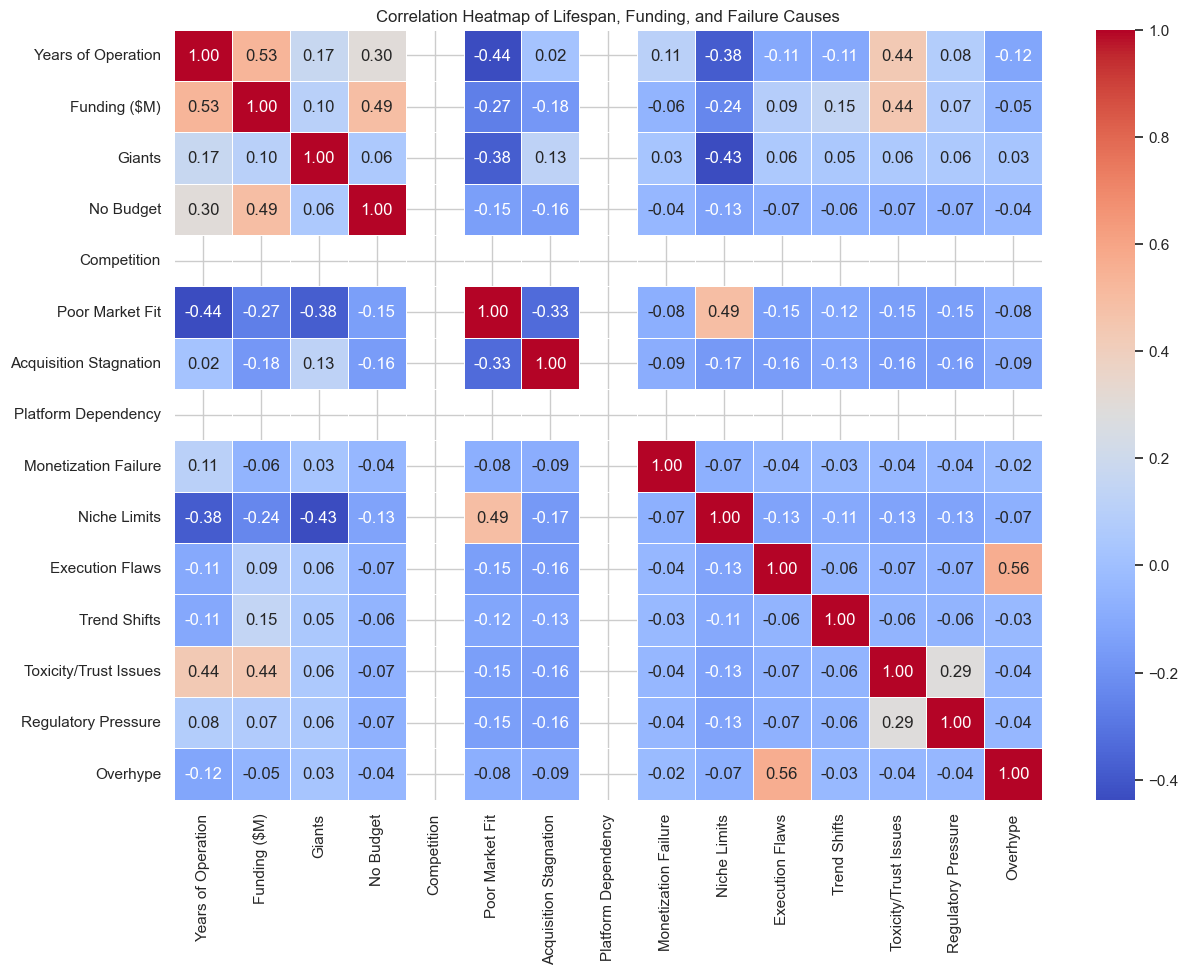

Positive/negative correlations between funding, lifespan, and failure causes.


In [434]:
# Select columns for correlation
corr_cols = ['Years of Operation', 'Funding ($M)'] + failure_flags
corr_matrix = data[corr_cols].corr()
# Generate Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Lifespan, Funding, and Failure Causes')
plt.show()
print("Positive/negative correlations between funding, lifespan, and failure causes.")

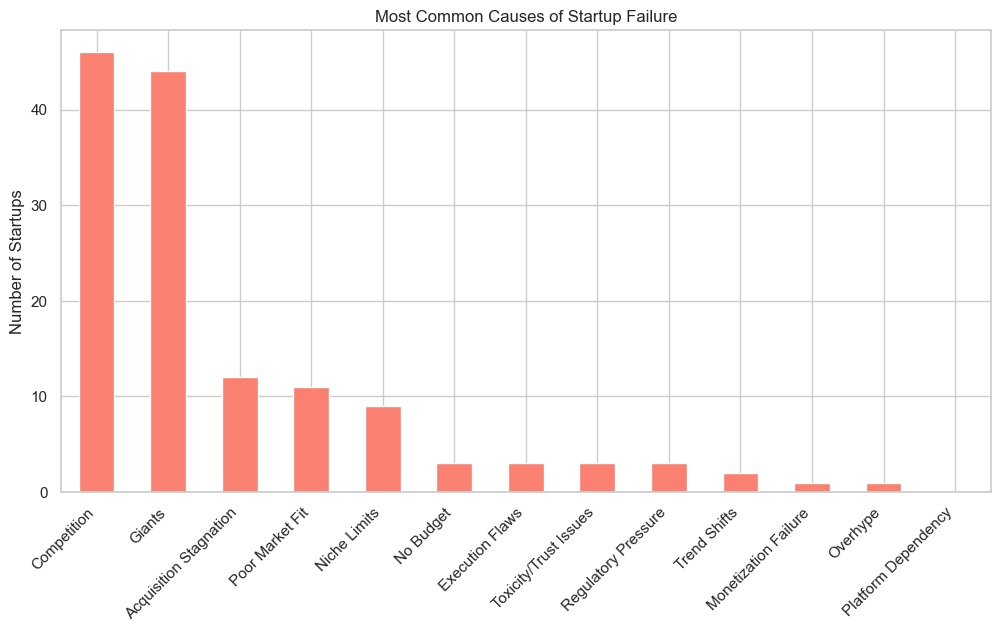

*Top Cause*: Competition with 46.0 cases.

All Causes:
- Competition: 46.0
- Giants: 44.0
- Acquisition Stagnation: 12.0
- Poor Market Fit: 11.0
- Niche Limits: 9.0
- No Budget: 3.0
- Execution Flaws: 3.0
- Toxicity/Trust Issues: 3.0
- Regulatory Pressure: 3.0
- Trend Shifts: 2.0
- Monetization Failure: 1.0
- Overhype: 1.0
- Platform Dependency: 0.0


/var/folders/09/7fcnlqx173v03wyt8sxj1lzh0000gn/T/ipykernel_52617/1405079135.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("*Top Cause*:", failure_sums.index[0], "with", failure_sums[0], "cases.")


In [435]:
failure_sums = data[failure_flags].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
failure_sums.plot(kind='bar', color='salmon')
plt.title('Most Common Causes of Startup Failure')
plt.ylabel('Number of Startups')
plt.xticks(rotation=45, ha='right')
plt.show()
print("*Top Cause*:", failure_sums.index[0], "with", failure_sums[0], "cases.")
print("\nAll Causes:")
for cause, count in failure_sums.items():
    print(f"- {cause}: {count}")

In [436]:
# Years of operation is a string like '2012-2023'. We need to convert this to three columns: the abs value of the difference in the current column and two new columns: start year, end year.
data = data.drop(columns=['start_year', 'end_year', "What They Did", "Why They Failed", "Takeaway", "Name"])
print(data.isnull().sum())
print(data.head(5))

Sector                    0
Years of Operation        0
How Much They Raised      0
Giants                    0
No Budget                 0
Competition               0
Poor Market Fit           0
Acquisition Stagnation    0
Platform Dependency       0
Monetization Failure      0
Niche Limits              0
Execution Flaws           0
Trend Shifts              0
Toxicity/Trust Issues     0
Regulatory Pressure       0
Overhype                  0
Funding ($M)              0
dtype: int64
                  Sector  Years of Operation How Much They Raised  Giants  \
0  Finance and Insurance                  11                $655M       1   
1  Finance and Insurance                   6                  $2M       1   
2  Finance and Insurance                   5                  $3M       1   
3  Finance and Insurance                  10                $500M       1   
4  Finance and Insurance                   6                 $11M       1   

   No Budget  Competition  Poor Market Fit  Acqu

In [437]:
# Convert Overhype to an integer
data['Poor Market Fit'] = data['Poor Market Fit'].astype(int)
# Remove $ and M from How Much They Raised

def extract_number(text):
    if pd.isna(text):
        return float('nan')
    # Extract the first number in the string (works for cases like "1.7B (Dropbox)" or "0 (SoFi-funded)")
    match = re.search(r'(\d+\.?\d*)', str(text))
    if match:
        number = float(match.group(1))
        # Handle B/M multipliers
        if 'B' in text:
            number *= 1000  # Convert billions to millions
        return number
    return float('nan')

# Apply the function to clean the column
data['How Much They Raised'] = data['How Much They Raised'].apply(extract_number)

print(data.head(5))

                  Sector  Years of Operation  How Much They Raised  Giants  \
0  Finance and Insurance                  11                 655.0       1   
1  Finance and Insurance                   6                   2.0       1   
2  Finance and Insurance                   5                   3.0       1   
3  Finance and Insurance                  10                 500.0       1   
4  Finance and Insurance                   6                  11.0       1   

   No Budget  Competition  Poor Market Fit  Acquisition Stagnation  \
0          1            1                0                       0   
1          0            1                1                       0   
2          0            1                0                       1   
3          0            1                0                       0   
4          0            1                0                       1   

   Platform Dependency  Monetization Failure  Niche Limits  Execution Flaws  \
0                    0         

In [438]:
label_encoder = LabelEncoder()
data["Sector"] = label_encoder.fit_transform(data["Sector"])

3. Use the sample code for the Ensemble classifier and modify it to work with the Startup
dataset.

In [439]:
X = data.drop('Poor Market Fit', axis=1)
Y = data['Poor Market Fit']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

4. Compare the performance a decision tree, bagging classifier, random forest and a
boosting classifier using all default settings and configuration used in the sample code.

Bagging Classifier Accuracy: 0.9000
Decision Tree Classifier Accuracy: 0.9000
Random Forest Classifier Accuracy: 0.8000
AdaBoost Classifier Accuracy: 0.9000


/var/folders/09/7fcnlqx173v03wyt8sxj1lzh0000gn/T/ipykernel_52617/811398730.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=accuracies, palette="viridis")


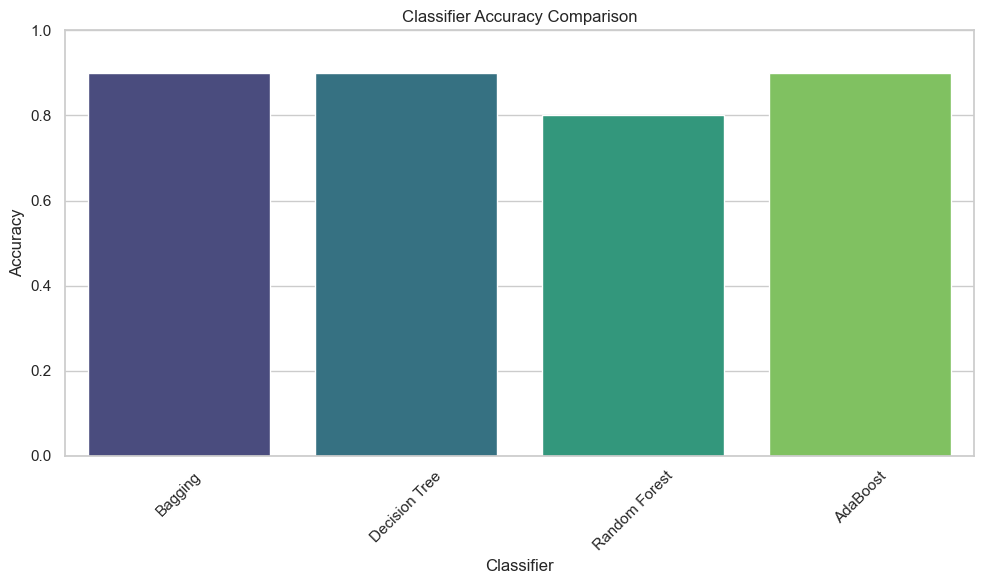

In [440]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, random_state=40)
bag_clf.fit(X_train, Y_train)
bag_y_pred = bag_clf.predict(X_test)


dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, Y_train)
dt_y_pred = dt_clf.predict(X_test)

rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rf_clf.fit(X_train, Y_train)
rf_y_pred = rf_clf.predict(X_test)
rf_y_prob = rf_clf.predict_proba(X_test)

ab_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    learning_rate=1.0, random_state=42)
ab_clf.fit(X_train, Y_train)
ab_y_pred = ab_clf.predict(X_test)

# Calculate and plot the accuracy scores
bag_accuracy = accuracy_score(Y_test, bag_y_pred)
dt_accuracy = accuracy_score(Y_test, dt_y_pred)
rf_accuracy = accuracy_score(Y_test, rf_y_pred)
ab_accuracy = accuracy_score(Y_test, ab_y_pred)
print(f"Bagging Classifier Accuracy: {bag_accuracy:.4f}")
print(f"Decision Tree Classifier Accuracy: {dt_accuracy:.4f}")
print(f"Random Forest Classifier Accuracy: {rf_accuracy:.4f}")
print(f"AdaBoost Classifier Accuracy: {ab_accuracy:.4f}")

# Plotting the accuracies
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the style
sns.set(style="whitegrid")
# Data for plotting
methods = ['Bagging', 'Decision Tree', 'Random Forest', 'AdaBoost']
accuracies = [bag_accuracy, dt_accuracy, rf_accuracy, ab_accuracy]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=methods, y=accuracies, palette="viridis")
plt.title('Classifier Accuracy Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


5. Modify the random forest classifier tree depth hyper-parameter for the depth of 2-7 and analyze and comment on the results of the impact of changing the tree depth on the performance (replace the max_leaf_nodes=16 with max_depth = 2 (change from 2-7) ).

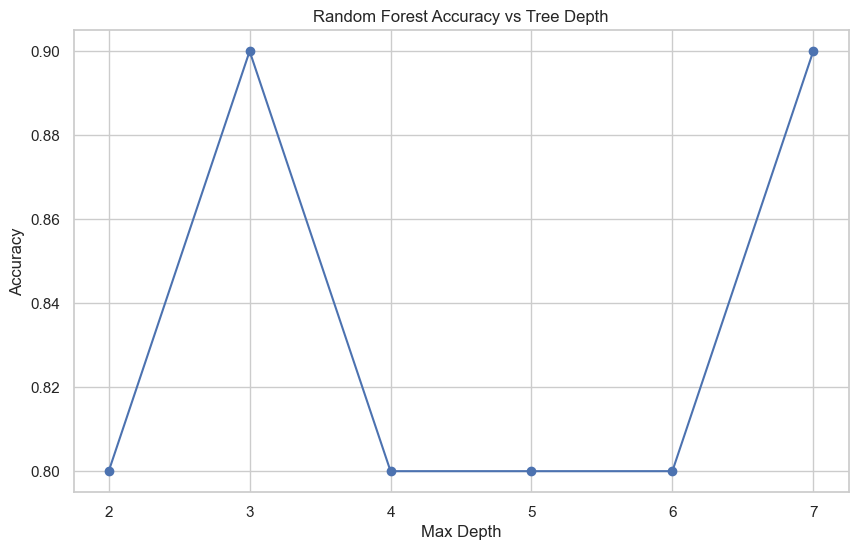

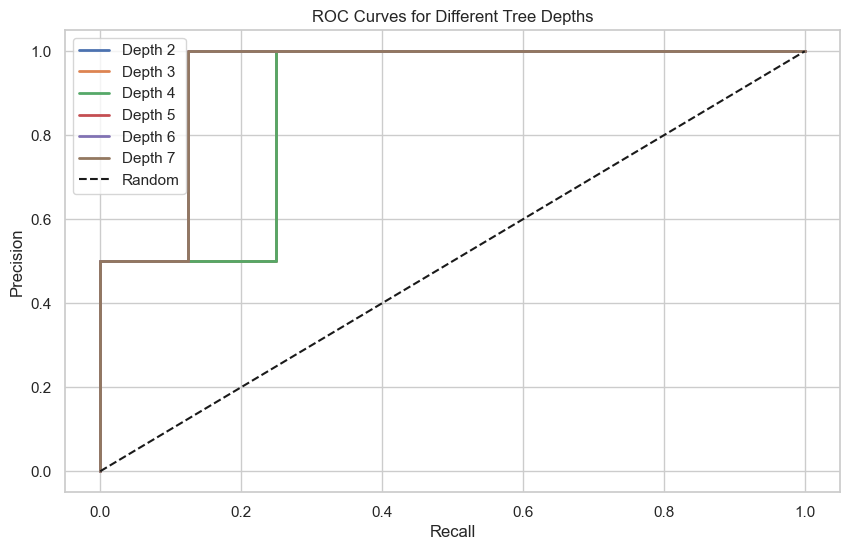

In [441]:
depths = list(range(2, 8))
accuracies = []
roc_curves = []

for depth in depths:
    rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=depth, n_jobs=-1, random_state=42)
    rf_clf.fit(X_train, Y_train)

    rf_y_pred = rf_clf.predict(X_test)
    accuracy = accuracy_score(Y_test, rf_y_pred)
    accuracies.append(accuracy)

    rf_y_prob = rf_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(Y_test, rf_y_prob)
    roc_curves.append((fpr, tpr))

plt.figure(figsize=(10, 6))

# Plot accuracy vs depth
plt.plot(depths, accuracies, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs Tree Depth')
plt.grid(True)
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i, depth in enumerate(depths):
    fpr, tpr = roc_curves[i]
    plt.plot(fpr, tpr, linewidth=2, label=f'Depth {depth}')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('ROC Curves for Different Tree Depths')
plt.legend()
plt.grid(True)
plt.show()

In [442]:
print("\nAccuracy scores for different tree depths:")
for depth, accuracy in zip(depths, accuracies):
    print(f"Max Depth {depth}: {accuracy:.4f}")

optimal_depth = depths[np.argmax(accuracies)]
print(f"\nOptimal tree depth: {optimal_depth} with accuracy: {max(accuracies):.4f}")


Accuracy scores for different tree depths:
Max Depth 2: 0.8000
Max Depth 3: 0.9000
Max Depth 4: 0.8000
Max Depth 5: 0.8000
Max Depth 6: 0.8000
Max Depth 7: 0.9000

Optimal tree depth: 3 with accuracy: 0.9000


Random Forest is highly stable, staying within the range of 0.8 and 0.9 accuracy score. The dataset is quite small, limiting the overall variability and resulting in step-like ROC curves.

6. For the Adaboost classifier, modify the learning rate to a higher rate and a low rate and analyze and comment on the results (you need to experiment with the learning rate to figure out what range makes sense).

<Figure size 1000x600 with 0 Axes>

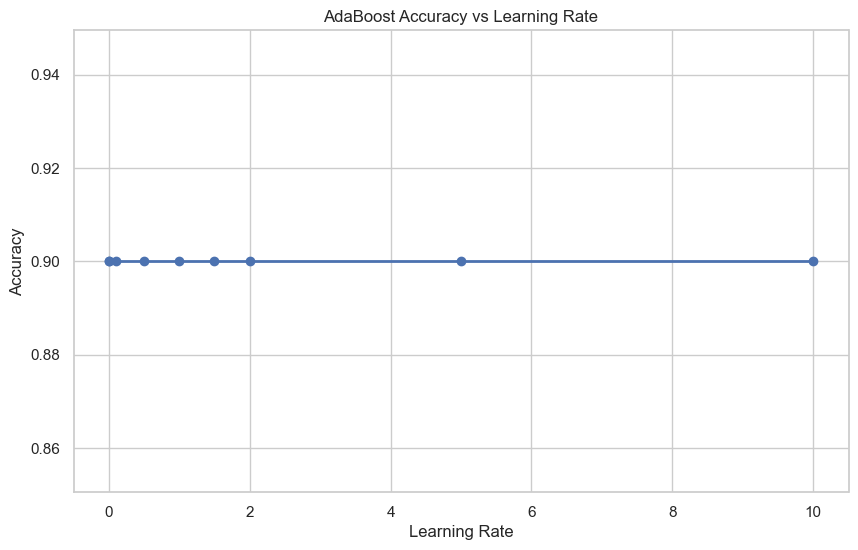

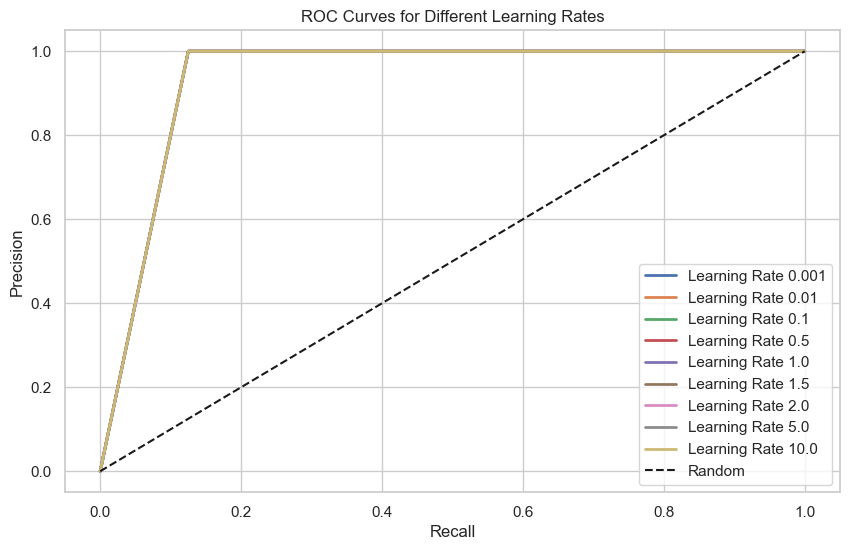

In [443]:
rates = [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0]
accuracies = []
roc_curves = []

for rate in rates:
    ab_clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500, learning_rate=rate, random_state=42)
    ab_clf.fit(X_train, Y_train)

    ab_y_pred = ab_clf.predict(X_test)
    accuracy = accuracy_score(Y_test, ab_y_pred)
    accuracies.append(accuracy)

    ab_y_prob = ab_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(Y_test, ab_y_prob)
    roc_curves.append((fpr, tpr))

plt.figure(figsize=(10, 6))

# Plot accuracy vs depth
plt.figure(figsize=(10, 6))
plt.plot(rates, accuracies, marker='o', linewidth=2)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('AdaBoost Accuracy vs Learning Rate')
plt.grid(True)
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i, lr in enumerate(rates):
    fpr, tpr = roc_curves[i]
    plt.plot(fpr, tpr, linewidth=2, label=f'Learning Rate {lr}')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('ROC Curves for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

In [444]:
print("\nAccuracy scores for different learning rates:")
for lr, accuracy in zip(rates, accuracies):
    print(f"Learning Rate {lr:.3f}: {accuracy:.4f}")

optimal_lr = rates[np.argmax(accuracies)]
print(f"\nOptimal learning rate: {optimal_lr:.3f} with accuracy: {max(accuracies):.4f}")


Accuracy scores for different learning rates:
Learning Rate 0.001: 0.9000
Learning Rate 0.010: 0.9000
Learning Rate 0.100: 0.9000
Learning Rate 0.500: 0.9000
Learning Rate 1.000: 0.9000
Learning Rate 1.500: 0.9000
Learning Rate 2.000: 0.9000
Learning Rate 5.000: 0.9000
Learning Rate 10.000: 0.9000

Optimal learning rate: 0.001 with accuracy: 0.9000


AdaBoost shows consistent result for varying learning rates. It strongly indicates that the small dataset contains very clear decision boundaries that are easily captured by the AdaBoost classifier, making the learning rate essentially irrelevant for this particular classification task.

7. Compare the performance of all models (all in steps 2-4) once again this time using cross-validation. Analyze the results and compare with the manual approach (steps 2-4)

In [445]:
def evaluate_each_model_in_turn(models, X, Y):
    results = []
    names = []
    scoring = 'accuracy'
    
    # Perform k-fold validation for each model
    for name, model in models.items():  # Changed from models to models.items()
        kfold = KFold(n_splits=10, random_state=42, shuffle=True)
        cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print(f"{name}: {cv_results.mean():.4f} (±{cv_results.std()*2:.4f})")
    
    # Create boxplot comparison
    plt.figure(figsize=(10, 6))
    plt.boxplot(results, labels=names)
    plt.title('Cross-Validation Model Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return dict(zip(names, [{'mean': r.mean(), 'std': r.std()} for r in results]))

Decision Tree: 0.8250 (±0.1803)
Bagging: 0.8050 (±0.2256)
Random Forest: 0.8250 (±0.2540)
AdaBoost: 0.8250 (±0.1803)


/var/folders/09/7fcnlqx173v03wyt8sxj1lzh0000gn/T/ipykernel_52617/847462075.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names)


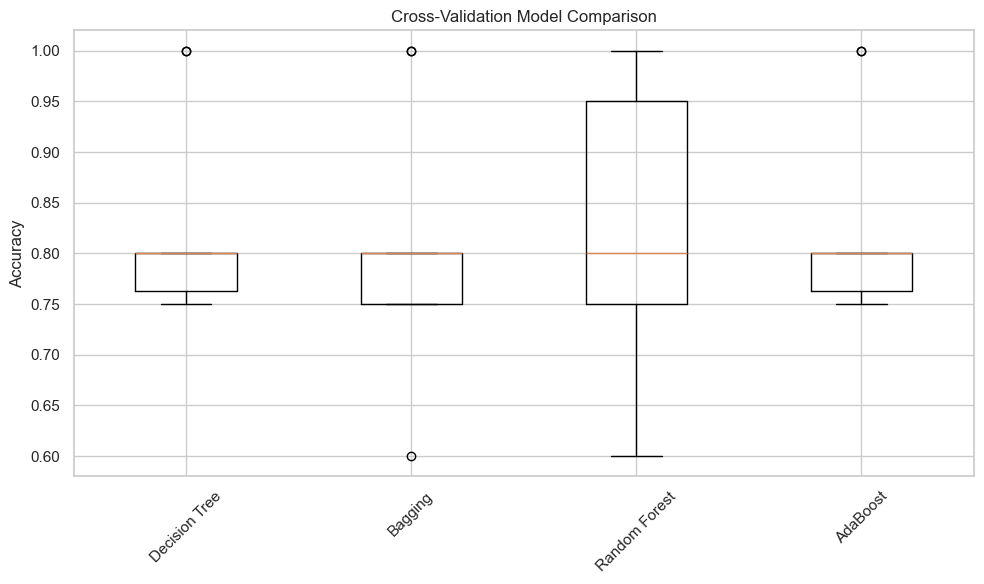


Comparison with previous non-CV results:
               Non-CV Accuracy  CV Mean Accuracy  CV Std Dev
Decision Tree              0.9             0.825      0.0901
Bagging                    0.9             0.805      0.1128
Random Forest              0.8             0.825      0.1270
AdaBoost                   0.9             0.825      0.0901


In [447]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Bagging': BaggingClassifier(
        DecisionTreeClassifier(random_state=42), 
        n_estimators=500,
        bootstrap=True, 
        n_jobs=-1, 
        random_state=40
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=500, 
        max_leaf_nodes=16, 
        n_jobs=-1, 
        random_state=42
    ),
    'AdaBoost': AdaBoostClassifier(
        DecisionTreeClassifier(random_state=42),
        n_estimators=500,
        learning_rate=1.0, 
        random_state=42
    )
}

# Use the function with your existing classifiers
cv_results = evaluate_each_model_in_turn(models, X, Y)

# Compare with previous non-CV results
comparison_df = pd.DataFrame({
    'Non-CV Accuracy': {
        'Decision Tree': dt_accuracy,
        'Bagging': bag_accuracy,
        'Random Forest': rf_accuracy,
        'AdaBoost': ab_accuracy
    },
    'CV Mean Accuracy': {name: results['mean'] for name, results in cv_results.items()},
    'CV Std Dev': {name: results['std'] for name, results in cv_results.items()}
})

print("\nComparison with previous non-CV results:")
print(comparison_df.round(4))